# Method 7 - Rest Ideas After 10

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Add Expected Returns from Intra-Cap Portfolio Weight per Shumway, Szefler, Yuan 2009

%store -r cap_exp_ret

valid_data = valid_data.merge(cap_exp_ret, on=['datadate', 'institution_id', 'fsym_id'], how='left')

# Calculate CSP Weight per Market Tilt

valid_data['adj_target'] = valid_data['expected_return']

## Calculate Rest Ideas

In [3]:
# Extract Rest Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] > 10].copy()

# Weight the best ideas

best_ideas['target'] = best_ideas['target'] / best_ideas.groupby([
    'datadate', 'institution_id'])['target'].transform('sum') * \
                        (1 / best_ideas.groupby('datadate')['institution_id']
                         .transform(lambda s: s.nunique()))

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

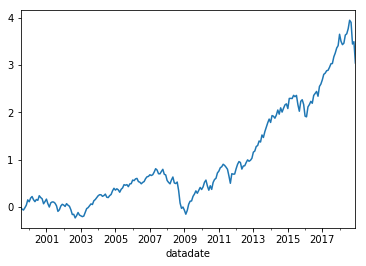

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.147846
2000-12-31   -0.031350
2001-12-31   -0.051677
2002-12-31   -0.216114
2003-12-31    0.444824
2004-12-31    0.166776
2005-12-31    0.070269
2006-12-31    0.103223
2007-12-31    0.018906
2008-12-31   -0.405521
2009-12-31    0.416581
2010-12-31    0.216988
2011-12-31   -0.013667
2012-12-31    0.197258
2013-12-31    0.408545
2014-12-31    0.112951
2015-12-31   -0.003820
2016-12-31    0.135825
2017-12-31    0.226063
2018-12-31   -0.083267
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                     3192.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.68e-199
Time:                        21:30:19   Log-Likelihood:                 849.56
No. Observations:                 234   AIC:                            -1689.
Df Residuals:                     229   BIC:                            -1672.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.000      4.853      0.000       0.001       0.003
mktrf          1.0362      0.012     85.708      0.000       1.012       1.060
me             0.2205      0.014     15.682      0.000       0.193       0.248
ia             0.0487      0.021      2.278      0.024       0.007       0.091
roe           -0.0196      0.018     -1.069      0.286      -0.056       0.016
==============================================================================
Omnibus:                       23.242   Durbin-Watson:                   1.797
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               92.384
Skew:                          -0.173   Prob(JB):                     8.69e-21
Kurtosis:                       6.059   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                     2464.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          6.93e-187
Time:                        21:30:19   Log-Likelihood:                 849.56
No. Observations:                 234   AIC:                            -1689.
Df Residuals:                     229   BIC:                            -1672.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.000      4.659      0.000       0.001       0.003
mktrf          1.0362      0.015     70.984      0.000       1.008       1.065
me             0.2205      0.026      8.328      0.000       0.169       0.272
ia             0.0487      0.044      1.115      0.265      -0.037       0.134
roe           -0.0196      0.027     -0.728      0.467      -0.072       0.033
==============================================================================
Omnibus:                       23.242   Durbin-Watson:                   1.797
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               92.384
Skew:                          -0.173   Prob(JB):                     8.69e-21
Kurtosis:                       6.059   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                     2770.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.37e-192
Time:                        21:30:19   Log-Likelihood:                 849.56
No. Observations:                 234   AIC:                            -1689.
Df Residuals:                     229   BIC:                            -1672.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.000      4.661      0.000       0.001       0.003
mktrf          1.0362      0.014     71.905      0.000       1.008       1.064
me             0.2205      0.024      9.197      0.000       0.174       0.268
ia             0.0487      0.045      1.085      0.278      -0.039       0.137
roe           -0.0196      0.030     -0.658      0.510      -0.078       0.039
==============================================================================
Omnibus:                       23.242   Durbin-Watson:                   1.797
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               92.384
Skew:                          -0.173   Prob(JB):                     8.69e-21
Kurtosis:                       6.059   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                     2206.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          7.76e-191
Time:                        21:30:19   Log-Likelihood:                 833.28
No. Observations:                 234   AIC:                            -1655.
Df Residuals:                     228   BIC:                            -1634.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.000      3.958      0.000       0.001       0.003
mktrf          1.0459      0.013     80.364      0.000       1.020       1.072
smb            0.2466      0.017     14.359      0.000       0.213       0.280
hml            0.0350      0.020      1.727      0.086      -0.005       0.075
rmw            0.0014      0.023      0.061      0.952      -0.044       0.046
cma            0.0146      0.029      0.501      0.617      -0.043       0.072
==============================================================================
Omnibus:                       24.186   Durbin-Watson:                   1.668
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              111.446
Skew:                           0.032   Prob(JB):                     6.31e-25
Kurtosis:                       6.380   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                     1613.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.05e-175
Time:                        21:30:19   Log-Likelihood:                 833.28
No. Observations:                 234   AIC:                            -1655.
Df Residuals:                     228   BIC:                            -1634.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.001      3.755      0.000       0.001       0.003
mktrf          1.0459      0.016     66.365      0.000       1.015       1.077
smb            0.2466      0.023     10.676      0.000       0.201       0.292
hml            0.0350      0.042      0.843      0.400      -0.046       0.116
rmw            0.0014      0.029      0.048      0.962      -0.055       0.058
cma            0.0146      0.042      0.346      0.729      -0.068       0.097
==============================================================================
Omnibus:                       24.186   Durbin-Watson:                   1.668
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              111.446
Skew:                           0.032   Prob(JB):                     6.31e-25
Kurtosis:                       6.380   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                     2022.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.33e-186
Time:                        21:30:19   Log-Likelihood:                 833.28
No. Observations:                 234   AIC:                            -1655.
Df Residuals:                     228   BIC:                            -1634.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.001      3.647      0.000       0.001       0.003
mktrf          1.0459      0.016     67.238      0.000       1.015       1.076
smb            0.2466      0.021     11.962      0.000       0.206       0.287
hml            0.0350      0.043      0.817      0.414      -0.049       0.119
rmw            0.0014      0.031      0.044      0.965      -0.060       0.063
cma            0.0146      0.041      0.359      0.719      -0.065       0.094
==============================================================================
Omnibus:                       24.186   Durbin-Watson:                   1.668
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              111.446
Skew:                           0.032   Prob(JB):                     6.31e-25
Kurtosis:                       6.380   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     2548.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.62e-188
Time:                        21:30:19   Log-Likelihood:                 823.71
No. Observations:                 234   AIC:                            -1637.
Df Residuals:                     229   BIC:                            -1620.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.000      4.344      0.000       0.001       0.003
mktrf          1.0383      0.012     83.524      0.000       1.014       1.063
smb            0.2331      0.016     15.023      0.000       0.203       0.264
hml            0.0839      0.015      5.444      0.000       0.054       0.114
umd           -0.0148      0.010     -1.463      0.145      -0.035       0.005
==============================================================================
Omnibus:                       22.140   Durbin-Watson:                   1.696
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               91.977
Skew:                           0.032   Prob(JB):                     1.07e-20
Kurtosis:                       6.071   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     2053.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          4.71e-178
Time:                        21:30:19   Log-Likelihood:                 823.71
No. Observations:                 234   AIC:                            -1637.
Df Residuals:                     229   BIC:                            -1620.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.001      3.420      0.001       0.001       0.003
mktrf          1.0383      0.017     60.350      0.000       1.005       1.072
smb            0.2331      0.024      9.666      0.000       0.186       0.280
hml            0.0839      0.045      1.881      0.060      -0.004       0.171
umd           -0.0148      0.018     -0.833      0.405      -0.050       0.020
==============================================================================
Omnibus:                       22.140   Durbin-Watson:                   1.696
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               91.977
Skew:                           0.032   Prob(JB):                     1.07e-20
Kurtosis:                       6.071   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     2592.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.33e-189
Time:                        21:30:19   Log-Likelihood:                 823.71
No. Observations:                 234   AIC:                            -1637.
Df Residuals:                     229   BIC:                            -1620.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.001      3.225      0.001       0.001       0.003
mktrf          1.0383      0.015     69.435      0.000       1.009       1.068
smb            0.2331      0.024      9.553      0.000       0.185       0.281
hml            0.0839      0.049      1.705      0.088      -0.013       0.180
umd           -0.0148      0.014     -1.030      0.303      -0.043       0.013
==============================================================================
Omnibus:                       22.140   Durbin-Watson:                   1.696
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               91.977
Skew:                           0.032   Prob(JB):                     1.07e-20
Kurtosis:                       6.071   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     1479.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.65e-98
Time:                        21:30:19   Log-Likelihood:                 418.93
No. Observations:                 120   AIC:                            -827.9
Df Residuals:                     115   BIC:                            -813.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.001      3.788      0.000       0.001       0.004
mktrf          1.0405      0.019     53.603      0.000       1.002       1.079
me             0.2019      0.019     10.533      0.000       0.164       0.240
ia             0.0973      0.030      3.240      0.002       0.038       0.157
roe           -0.0266      0.027     -1.000      0.319      -0.079       0.026
==============================================================================
Omnibus:                        8.790   Durbin-Watson:                   1.747
Prob(Omnibus):                  0.012   Jarque-Bera (JB):               17.620
Skew:                          -0.151   Prob(JB):                     0.000149
Kurtosis:                       4.853   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     1364.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.07e-96
Time:                        21:30:19   Log-Likelihood:                 418.93
No. Observations:                 120   AIC:                            -827.9
Df Residuals:                     115   BIC:                            -813.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.001      3.311      0.001       0.001       0.004
mktrf          1.0405      0.023     45.885      0.000       0.996       1.085
me             0.2019      0.026      7.679      0.000       0.150       0.253
ia             0.0973      0.045      2.143      0.032       0.008       0.186
roe           -0.0266      0.030     -0.880      0.379      -0.086       0.033
==============================================================================
Omnibus:                        8.790   Durbin-Watson:                   1.747
Prob(Omnibus):                  0.012   Jarque-Bera (JB):               17.620
Skew:                          -0.151   Prob(JB):                     0.000149
Kurtosis:                       4.853   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     2160.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          3.74e-107
Time:                        21:30:19   Log-Likelihood:                 418.93
No. Observations:                 120   AIC:                            -827.9
Df Residuals:                     115   BIC:                            -813.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.001      3.059      0.002       0.001       0.004
mktrf          1.0405      0.020     51.733      0.000       1.001       1.080
me             0.2019      0.024      8.382      0.000       0.155       0.249
ia             0.0973      0.038      2.534      0.011       0.022       0.173
roe           -0.0266      0.031     -0.846      0.398      -0.088       0.035
==============================================================================
Omnibus:                        8.790   Durbin-Watson:                   1.747
Prob(Omnibus):                  0.012   Jarque-Bera (JB):               17.620
Skew:                          -0.151   Prob(JB):                     0.000149
Kurtosis:                       4.853   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     970.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.18e-91
Time:                        21:30:19   Log-Likelihood:                 407.83
No. Observations:                 120   AIC:                            -803.7
Df Residuals:                     114   BIC:                            -786.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.001      3.542      0.001       0.001       0.004
mktrf          1.0836      0.023     48.054      0.000       1.039       1.128
smb            0.2496      0.026      9.774      0.000       0.199       0.300
hml            0.0121      0.031      0.388      0.699      -0.050       0.074
rmw            0.0365      0.037      0.990      0.324      -0.037       0.110
cma            0.0822      0.040      2.032      0.044       0.002       0.162
==============================================================================
Omnibus:                       12.727   Durbin-Watson:                   1.743
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               36.216
Skew:                          -0.169   Prob(JB):                     1.37e-08
Kurtosis:                       5.670   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     1087.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.18e-94
Time:                        21:30:19   Log-Likelihood:                 407.83
No. Observations:                 120   AIC:                            -803.7
Df Residuals:                     114   BIC:                            -786.9
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.001      3.257      0.001       0.001       0.005
mktrf          1.0836      0.028     39.333      0.000       1.030       1.138
smb            0.2496      0.034      7.325      0.000       0.183       0.316
hml            0.0121      0.068      0.179      0.858      -0.121       0.145
rmw            0.0365      0.051      0.717      0.473      -0.063       0.136
cma            0.0822      0.048      1.723      0.085      -0.011       0.176
==============================================================================
Omnibus:                       12.727   Durbin-Watson:                   1.743
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               36.216
Skew:                          -0.169   Prob(JB):                     1.37e-08
Kurtosis:                       5.670   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     2028.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.39e-109
Time:                        21:30:19   Log-Likelihood:                 407.83
No. Observations:                 120   AIC:                            -803.7
Df Residuals:                     114   BIC:                            -786.9
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.001      3.169      0.002       0.001       0.005
mktrf          1.0836      0.026     42.316      0.000       1.033       1.134
smb            0.2496      0.031      7.971      0.000       0.188       0.311
hml            0.0121      0.072      0.169      0.866      -0.129       0.153
rmw            0.0365      0.055      0.667      0.505      -0.071       0.144
cma            0.0822      0.044      1.849      0.065      -0.005       0.169
==============================================================================
Omnibus:                       12.727   Durbin-Watson:                   1.743
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               36.216
Skew:                          -0.169   Prob(JB):                     1.37e-08
Kurtosis:                       5.670   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     1086.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.54e-90
Time:                        21:30:19   Log-Likelihood:                 400.85
No. Observations:                 120   AIC:                            -791.7
Df Residuals:                     115   BIC:                            -777.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0034      0.001      4.160      0.000       0.002       0.005
mktrf          1.0492      0.020     52.773      0.000       1.010       1.089
smb            0.2297      0.023     10.146      0.000       0.185       0.275
hml            0.1085      0.023      4.787      0.000       0.064       0.153
umd           -0.0144      0.014     -1.032      0.304      -0.042       0.013
==============================================================================
Omnibus:                       11.019   Durbin-Watson:                   1.730
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               28.434
Skew:                          -0.106   Prob(JB):                     6.69e-07
Kurtosis:                       5.375   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     1491.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.78e-98
Time:                        21:30:19   Log-Likelihood:                 400.85
No. Observations:                 120   AIC:                            -791.7
Df Residuals:                     115   BIC:                            -777.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0034      0.001      3.794      0.000       0.002       0.005
mktrf          1.0492      0.027     39.448      0.000       0.997       1.101
smb            0.2297      0.028      8.312      0.000       0.176       0.284
hml            0.1085      0.055      1.977      0.048       0.001       0.216
umd           -0.0144      0.021     -0.689      0.491      -0.055       0.027
==============================================================================
Omnibus:                       11.019   Durbin-Watson:                   1.730
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               28.434
Skew:                          -0.106   Prob(JB):                     6.69e-07
Kurtosis:                       5.375   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     2582.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.46e-111
Time:                        21:30:19   Log-Likelihood:                 400.85
No. Observations:                 120   AIC:                            -791.7
Df Residuals:                     115   BIC:                            -777.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0034      0.001      3.591      0.000       0.002       0.005
mktrf          1.0492      0.020     51.909      0.000       1.010       1.089
smb            0.2297      0.029      7.966      0.000       0.173       0.286
hml            0.1085      0.059      1.848      0.065      -0.007       0.224
umd           -0.0144      0.016     -0.895      0.371      -0.046       0.017
==============================================================================
Omnibus:                       11.019   Durbin-Watson:                   1.730
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               28.434
Skew:                          -0.106   Prob(JB):                     6.69e-07
Kurtosis:                       5.375   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     2550.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.14e-106
Time:                        21:30:19   Log-Likelihood:                 459.67
No. Observations:                 114   AIC:                            -909.3
Df Residuals:                     109   BIC:                            -895.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.000      3.887      0.000       0.001       0.003
mktrf          1.0317      0.013     79.961      0.000       1.006       1.057
me             0.2628      0.020     13.190      0.000       0.223       0.302
ia            -0.1006      0.028     -3.641      0.000      -0.155      -0.046
roe           -0.0557      0.024     -2.292      0.024      -0.104      -0.008
==============================================================================
Omnibus:                       12.062   Durbin-Watson:                   2.160
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               13.499
Skew:                          -0.657   Prob(JB):                      0.00117
Kurtosis:                       4.055   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     3807.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          4.53e-116
Time:                        21:30:19   Log-Likelihood:                 459.67
No. Observations:                 114   AIC:                            -909.3
Df Residuals:                     109   BIC:                            -895.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.000      4.509      0.000       0.001       0.002
mktrf          1.0317      0.010    102.309      0.000       1.012       1.051
me             0.2628      0.018     14.748      0.000       0.228       0.298
ia            -0.1006      0.026     -3.930      0.000      -0.151      -0.050
roe           -0.0557      0.022     -2.499      0.012      -0.099      -0.012
==============================================================================
Omnibus:                       12.062   Durbin-Watson:                   2.160
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               13.499
Skew:                          -0.657   Prob(JB):                      0.00117
Kurtosis:                       4.055   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     3824.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          3.58e-116
Time:                        21:30:19   Log-Likelihood:                 459.67
No. Observations:                 114   AIC:                            -909.3
Df Residuals:                     109   BIC:                            -895.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.000      4.651      0.000       0.001       0.002
mktrf          1.0317      0.010    103.165      0.000       1.012       1.051
me             0.2628      0.017     15.372      0.000       0.229       0.296
ia            -0.1006      0.028     -3.605      0.000      -0.155      -0.046
roe           -0.0557      0.022     -2.536      0.011      -0.099      -0.013
==============================================================================
Omnibus:                       12.062   Durbin-Watson:                   2.160
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               13.499
Skew:                          -0.657   Prob(JB):                      0.00117
Kurtosis:                       4.055   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                     3146.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          3.23e-115
Time:                        21:30:19   Log-Likelihood:                 484.66
No. Observations:                 114   AIC:                            -957.3
Df Residuals:                     108   BIC:                            -940.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.000      2.679      0.009       0.000       0.002
mktrf          1.0320      0.010    103.944      0.000       1.012       1.052
smb            0.2252      0.016     13.970      0.000       0.193       0.257
hml            0.0252      0.021      1.227      0.222      -0.016       0.066
rmw           -0.1420      0.025     -5.640      0.000      -0.192      -0.092
cma           -0.1436      0.032     -4.493      0.000      -0.207      -0.080
==============================================================================
Omnibus:                        3.828   Durbin-Watson:                   2.214
Prob(Omnibus):                  0.147   Jarque-Bera (JB):                3.392
Skew:                          -0.417   Prob(JB):                        0.183
Kurtosis:                       3.141   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                     2617.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          6.20e-111
Time:                        21:30:19   Log-Likelihood:                 484.66
No. Observations:                 114   AIC:                            -957.3
Df Residuals:                     108   BIC:                            -940.9
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.000      3.028      0.002       0.000       0.002
mktrf          1.0320      0.011     93.063      0.000       1.010       1.054
smb            0.2252      0.016     14.453      0.000       0.195       0.256
hml            0.0252      0.018      1.370      0.171      -0.011       0.061
rmw           -0.1420      0.017     -8.261      0.000      -0.176      -0.108
cma           -0.1436      0.030     -4.750      0.000      -0.203      -0.084
==============================================================================
Omnibus:                        3.828   Durbin-Watson:                   2.214
Prob(Omnibus):                  0.147   Jarque-Bera (JB):                3.392
Skew:                          -0.417   Prob(JB):                        0.183
Kurtosis:                       3.141   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                     3436.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.83e-117
Time:                        21:30:19   Log-Likelihood:                 484.66
No. Observations:                 114   AIC:                            -957.3
Df Residuals:                     108   BIC:                            -940.9
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.000      2.842      0.004       0.000       0.002
mktrf          1.0320      0.010     99.728      0.000       1.012       1.052
smb            0.2252      0.014     15.758      0.000       0.197       0.253
hml            0.0252      0.017      1.453      0.146      -0.009       0.059
rmw           -0.1420      0.019     -7.551      0.000      -0.179      -0.105
cma           -0.1436      0.028     -5.177      0.000      -0.198      -0.089
==============================================================================
Omnibus:                        3.828   Durbin-Watson:                   2.214
Prob(Omnibus):                  0.147   Jarque-Bera (JB):                3.392
Skew:                          -0.417   Prob(JB):                        0.183
Kurtosis:                       3.141   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     2543.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.32e-106
Time:                        21:30:19   Log-Likelihood:                 459.52
No. Observations:                 114   AIC:                            -909.0
Df Residuals:                     109   BIC:                            -895.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.000      1.209      0.229      -0.000       0.001
mktrf          1.0447      0.012     85.324      0.000       1.020       1.069
smb            0.2581      0.019     13.518      0.000       0.220       0.296
hml           -0.0079      0.020     -0.403      0.688      -0.047       0.031
umd           -0.0224      0.015     -1.508      0.134      -0.052       0.007
==============================================================================
Omnibus:                        3.679   Durbin-Watson:                   1.911
Prob(Omnibus):                  0.159   Jarque-Bera (JB):                3.174
Skew:                          -0.397   Prob(JB):                        0.205
Kurtosis:                       3.198   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     1778.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.01e-98
Time:                        21:30:19   Log-Likelihood:                 459.52
No. Observations:                 114   AIC:                            -909.0
Df Residuals:                     109   BIC:                            -895.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.000      1.239      0.215      -0.000       0.001
mktrf          1.0447      0.015     69.181      0.000       1.015       1.074
smb            0.2581      0.016     16.042      0.000       0.227       0.290
hml           -0.0079      0.017     -0.456      0.649      -0.042       0.026
umd           -0.0224      0.016     -1.408      0.159      -0.054       0.009
==============================================================================
Omnibus:                        3.679   Durbin-Watson:                   1.911
Prob(Omnibus):                  0.159   Jarque-Bera (JB):                3.174
Skew:                          -0.397   Prob(JB):                        0.205
Kurtosis:                       3.198   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     3006.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.59e-110
Time:                        21:30:19   Log-Likelihood:                 459.52
No. Observations:                 114   AIC:                            -909.0
Df Residuals:                     109   BIC:                            -895.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.000      1.336      0.182      -0.000       0.001
mktrf          1.0447      0.015     71.811      0.000       1.016       1.073
smb            0.2581      0.012     22.280      0.000       0.235       0.281
hml           -0.0079      0.014     -0.583      0.560      -0.035       0.019
umd           -0.0224      0.016     -1.376      0.169      -0.054       0.010
==============================================================================
Omnibus:                        3.679   Durbin-Watson:                   1.911
Prob(Omnibus):                  0.159   Jarque-Bera (JB):                3.174
Skew:                          -0.397   Prob(JB):                        0.205
Kurtosis:                       3.198   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""